In [ ]:
import pandas as pd
from termcolor import colored
from sklearn.model_selection import train_test_split

# Define variables
COLUMNS = ['Sentiment', 'Id', 'Date', 'Flag', 'User', 'Tweet']

# Read dataset
dataset = pd.read_csv('dataset.csv', names = COLUMNS, encoding = 'latin-1')
print(colored("Columns: {}".format(', '.join(COLUMNS)), "yellow"))

# Remove extra columns
print(colored("Useful columns: Sentiment and Tweet", "yellow"))
print(colored("Removing other columns", "red"))
dataset.drop(['Id', 'Date', 'Flag', 'User'], axis = 1, inplace = True)
print(colored("Columns removed", "red"))

# Train test split
print(colored("Splitting train and test dataset into 80:20", "yellow"))
X_train, X_test, y_train, y_test = train_test_split(dataset['Tweet'], dataset['Sentiment'], test_size = 0.20, random_state = 100)
train_dataset = pd.DataFrame({
	'Tweet': X_train,
	'Sentiment': y_train
	})
print(colored("Train data distribution:", "yellow"))
print(train_dataset['Sentiment'].value_counts())
test_dataset = pd.DataFrame({
	'Tweet': X_test,
	'Sentiment': y_test
	})
print(colored("Test data distribution:", "yellow"))
print(test_dataset['Sentiment'].value_counts())
print(colored("Split complete", "yellow"))

# Save train data
print(colored("Saving train data", "yellow"))

train_dataset.to_csv('train.csv', index = False)
print(colored("Train data saved to train.csv", "green"))

# Save test data
print(colored("Saving test data", "yellow"))
test_dataset.to_csv('test.csv', index = False)
print(colored("Test data saved to test.csv", "green"))

Columns: Sentiment, Id, Date, Flag, User, Tweet
Useful columns: Sentiment and Tweet
Removing other columns
Columns removed
Splitting train and test dataset into 80:20
Train data distribution:
Sentiment
4    640434
0    639566
Name: count, dtype: int64
Test data distribution:
Sentiment
0    160434
4    159566
Name: count, dtype: int64
Split complete
Saving train data
Train data saved to train.csv
Saving test data
Test data saved to test.csv


In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from termcolor import colored
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Import datasets
print("Loading data")
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Setting stopwords
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove("not")

# Function to expand tweet
def expand_tweet(tweet):
	expanded_tweet = []
	for word in tweet:
		if re.search("n't", word):
			expanded_tweet.append(word.split("n't")[0])
			expanded_tweet.append("not")
		else:
			expanded_tweet.append(word)
	return expanded_tweet

# Function to process tweets
def clean_tweet(data, wordNetLemmatizer, porterStemmer):
	data['Clean_tweet'] = data['Tweet']
	print(colored("Removing user handles starting with @", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("@[\w]*","")
	print(colored("Removing numbers and special characters", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("[^a-zA-Z' ]","")
	print(colored("Removing urls", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"((www\.[^\s]+)|(https?://[^\s]+))"), "")
	print(colored("Removing single characters", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"(^| ).( |$)"), " ")
	print(colored("Tokenizing", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].str.split()
	print(colored("Removing stopwords", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [word for word in tweet if word not in STOPWORDS])
	print(colored("Expanding not words", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: expand_tweet(tweet))
	print(colored("Lemmatizing the words", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [wordNetLemmatizer.lemmatize(word) for word in tweet])
	print(colored("Stemming the words", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [porterStemmer.stem(word) for word in tweet])
	print(colored("Combining words back to tweets", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: ' '.join(tweet))
	return data

# Define processing methods
wordNetLemmatizer = WordNetLemmatizer()
porterStemmer = PorterStemmer()

# Pre-processing the tweets
print(colored("Processing train data", "green"))
train_data = clean_tweet(train_data, wordNetLemmatizer, porterStemmer)
train_data.to_csv('clean_train.csv', index = False)
print(colored("Train data processed and saved to clean_train.csv", "green"))
print(colored("Processing test data", "green"))
test_data = clean_tweet(test_data, wordNetLemmatizer, porterStemmer)
test_data.to_csv('clean_test.csv', index = False)
print(colored("Test data processed and saved to clean_test.csv", "green"))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Loading data
Processing train data
Removing user handles starting with @
Removing numbers and special characters
Removing urls
Removing single characters
Tokenizing
Removing stopwords
Expanding not words
Lemmatizing the words
Stemming the words
Combining words back to tweets
Train data processed and saved to clean_train.csv
Processing test data
Removing user handles starting with @
Removing numbers and special characters
Removing urls
Removing single characters
Tokenizing
Removing stopwords
Expanding not words
Lemmatizing the words
Stemming the words
Combining words back to tweets
Test data processed and saved to clean_test.csv


In [ ]:
import os
import tensorflow
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences




import pandas as pd
from termcolor import colored

# Load data
print(colored("Loading train and test data", "yellow"))
train_data = pd.read_csv('clean_train.csv')
test_data = pd.read_csv('clean_test.csv')
print(colored("Data loaded", "yellow"))

Loading train and test data
Data loaded


In [ ]:
# Orijinal küme:
full_train = pd.read_csv('clean_train.csv')

# Yalnızca bir kez %25 altküme al:
subsampled_train = (
    full_train
    .groupby('Sentiment', group_keys=False)
    .sample(frac=0.25, random_state=100)
    .reset_index(drop=True)
)

print(subsampled_train['Sentiment'].value_counts())
# → 4: ~160 000, 0: ~160 000


Sentiment
4    160108
0    159892
Name: count, dtype: int64


In [ ]:
# Tokenization
print(colored("Tokenizing and padding data", "yellow"))
tokenizer = Tokenizer(num_words = 2000, split = ' ')
tokenizer.fit_on_texts(train_data['Clean_tweet'].astype(str).values)
train_tweets = tokenizer.texts_to_sequences(train_data['Clean_tweet'].astype(str).values)
max_len = max([len(i) for i in train_tweets])
train_tweets = pad_sequences(train_tweets, maxlen = max_len)
test_tweets = tokenizer.texts_to_sequences(test_data['Clean_tweet'].astype(str).values)
test_tweets = pad_sequences(test_tweets, maxlen = max_len)
print(colored("Tokenizing and padding complete", "yellow"))

Tokenizing and padding data
Tokenizing and padding complete


- **Embedding**  
- **SpatialDropout1D**  
- **LSTM**  
  - `units=256`  
  - `dropout=0.2`  
- **Dense**  
  - `units=2`  
  - `activation='softmax'`  


In [ ]:
# Building the model
print(colored("Creating the LSTM model", "yellow"))
model = Sequential()
model.add(Embedding(input_dim=2000, output_dim=128, input_shape=(train_tweets.shape[1],)))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Creating the LSTM model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 40, 128)        │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 40, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 650,754 (2.48 MB)

 Trainable params: 650,754 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model
print(colored("Training the LSTM model", "green"))
history = model.fit(train_tweets, pd.get_dummies(train_data['Sentiment']).values, epochs = 12, batch_size = 128, validation_split = 0.2)
print(colored(history, "green"))

Training the LSTM model
Epoch 1/12
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 2901s 362ms/step - accuracy: 0.7530 - loss: 0.5006 - val_accuracy: 0.7778 - val_loss: 0.4641
Epoch 2/12
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 2855s 357ms/step - accuracy: 0.7776 - loss: 0.4640 - val_accuracy: 0.7812 - val_loss: 0.4592
Epoch 3/12
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 2875s 359ms/step - accuracy: 0.7829 - loss: 0.4555 - val_accuracy: 0.7837 - val_loss: 0.4541
Epoch 4/12
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 2851s 356ms/step - accuracy: 0.7854 - loss: 0.4507 - val_accuracy: 0.7846 - val_loss: 0.4517
Epoch 5/12
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 2845s 349ms/step - accuracy: 0.7882 - loss: 0.4462 - val_accuracy: 0.7861 - val_loss: 0.4512
Epoch 6/12
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 2852s 357ms/step - accuracy: 0.7903 - loss: 0.4424 - val_accuracy: 0.7867 - val_loss: 0.4504
Epoch 7/12
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 2940s 361ms/step - accuracy: 0.7935 - loss: 0.4377 - val_accuracy: 0.7872 - val_loss: 0.4488
Epoch 8/12
8000/8000 ━━━━━━━━━━

In [ ]:
# --- Test Verisini Hazırlama ---
print(colored("Preparing test data", "yellow"))
# 1. Eksik değerleri boş string ile doldur ve string’e çevir
test_data['Clean_tweet'] = test_data['Clean_tweet'].fillna('').astype(str)
# 2. Tokenizer ile dizilere dönüştür
test_seq = tokenizer.texts_to_sequences(test_data['Clean_tweet'].values)
# 3. Eğitimde kullandığımız max_len ile pad et
X_test = pad_sequences(test_seq, maxlen=max_len)
# 4. Etiketleri one-hot encode et
y_test = pd.get_dummies(test_data['Sentiment']).values

Preparing test data


In [ ]:
# --- Modeli Test Etme ---
print(colored("Testing the LSTM model", "green"))
score, accuracy = model.evaluate(
    X_test, y_test,
    batch_size=128,
    verbose=1
)
print(f"Test loss: {score:.4f}, Test accuracy: {accuracy:.4f}")

Testing the LSTM model
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 280s 112ms/step - accuracy: 0.7878 - loss: 0.4480
Test loss: 0.4482, Test accuracy: 0.7876


In [ ]:
# --- Modeli Kaydet ---
model.save('lstm_model.h5')
print(colored("Model saved to lstm_model.h5", "green"))

Model saved to lstm_model.h5


In [ ]:
# --- Eğitim Geçmişini Kaydet ---
import pickle
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)
print(colored("Training history saved to training_history.pkl", "green"))

Training history saved to training_history.pkl


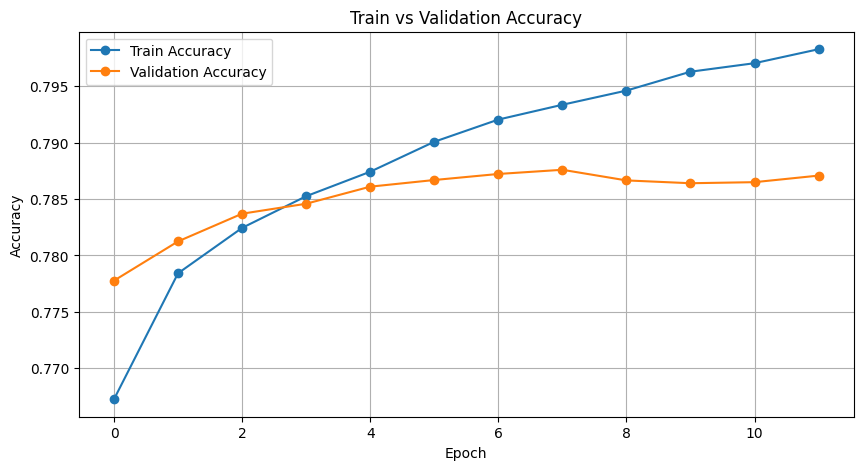

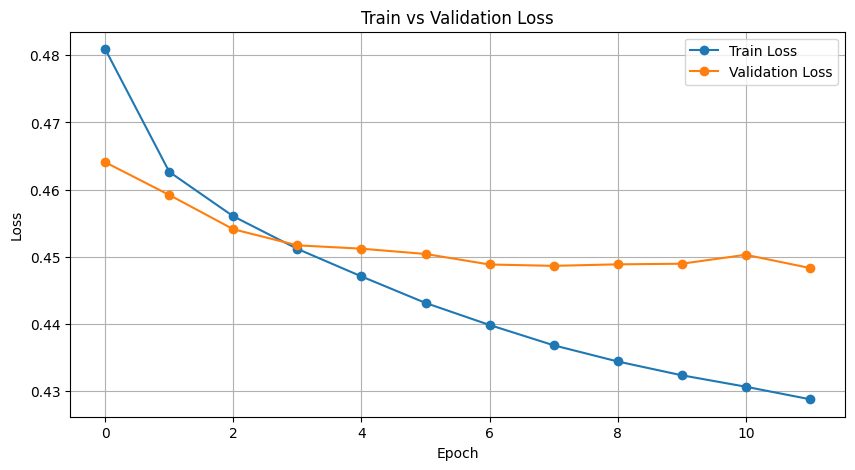

In [ ]:
# --- Eğitim/Validasyon Grafikleri ---
import matplotlib.pyplot as plt

# Eğitim ve doğrulama accuracy grafiği
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png')
plt.show()

# Eğitim ve doğrulama loss grafiği
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()